### First attempt at VMC
Using Variational Monte Carlo to find the ground state of a particle with potential $V(x) =\frac{1}{2} m\omega^2x^2 + \lambda x^4$.

We want to minimize the expected ground state energy:
$$\varepsilon = \frac{\int dX \, \psi^\dagger(X)\hat{H}\psi(X)}{\int dX\, \psi^\dagger(X) \psi(X)} = \frac{\int dX \, \psi^2(X)\psi^{-1}(X)\hat{H}\psi(X)}{\int dX\, \psi^2(X)}$$


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random
import sympy as sym

# constants for the potential
m = 1
omega = 1
lam = 0
hbar = 1
N = 10**4


x = sym.Symbol('x')
a = sym.Symbol('a')

sym_psi = (2*a / np.pi)**(1/4) * sym.exp(-a*x**2)
sym_ddpsi = sym.diff(sym.diff(sym_psi, x), x)
partial_a = sym.diff(sym.log(sym_psi),a)
grad_log_psi = sym.lambdify([x,a], partial_a)

# potential function
def V(x_inp):
    return 1/2*m * omega**2 * x_inp**2 + lam * x_inp**4

psi = sym.lambdify([x, a], sym_psi, dummify=True)
ddpsi = sym.lambdify([x, a], sym_ddpsi, dummify=True)

def Hpsi(x_inp,a):
    return V(x_inp) * psi(x_inp, a)  -hbar**2 / (2*m) * ddpsi(x_inp, a)

# function that samples the probability distribution P, n times
# uses the metropolis algorithm
# for any more than n=1, returns an array
def sample(a, n = 1):
    outputs = []
    # pick the start point
    x_t = 0
    for t in range(n):
        x_prime = x_t + random.uniform(-1,1)
        
        if (random.uniform(0,1) < psi(x_prime, a)**2/psi(x_t, a)**2):
            x_t = x_prime
        outputs.append(x_t)
    if n == 1:
        return outputs[0]
    return outputs


# now we define the approximation of the average, which uses the metropolis sampling
def avg_energy(N, a):
    # get N sampled points
    samples = sample(a, N)
    # apply the function to every point
    applied = [(1/psi(x_a, a) * Hpsi(x_a,a)) for x_a in samples]
    return 1/N * sum(applied)

# definition of the gradient
def gradient(a_inp, N):
    samples = sample(a_inp, N)
    energy_exp = 1/N * sum([(1/psi(x_a, a_inp) * Hpsi(x_a, a_inp)) for x_a in samples])
    gradlogpsi_exp = 1/N * sum([grad_log_psi(x_a, a_inp) for x_a in samples], 0)
    both_exp = 1/N * sum([(1/psi(x_a, a_inp) * grad_log_psi(x_a, a_inp) * Hpsi(x_a, a_inp)) for x_a in samples], 0)
    return (2 * both_exp - 2 * energy_exp * gradlogpsi_exp)

# define the gradient descent algorithm
def grad_opt(a_0, lr, max_iterations=10000, tolerance=.001, N=10**4):
    a = a_0
    hist = []
    for _ in range(max_iterations):
        # gradient in this case is just a number
        diff = lr * gradient(a, N)
        # print("parameter value: " + str(a))
        # print("gradient: " + str(diff / lr))
        if abs(diff) < tolerance:
            return a
        a = a - diff
        hist.append(a)
    return a



In [5]:
avals = [.3,.4,.5,.6,.7]
xvals = [.5, 1.2]
for a_val in avals:
    for x_val in xvals:
        print("parameter value: " + str(a_val) + ", x value: " + str(x_val))
        print(grad_log_psi(x_val,a_val))

parameter value: 0.3, x value: 0.5
0.5833333333333359
parameter value: 0.3, x value: 1.2
-0.606666666666666
parameter value: 0.4, x value: 0.5
0.375000000000002
parameter value: 0.4, x value: 1.2
-0.8150000000000001
parameter value: 0.5, x value: 0.5
0.2500000000000015
parameter value: 0.5, x value: 1.2
-0.9400000000000004
parameter value: 0.6, x value: 0.5
0.1666666666666678
parameter value: 0.6, x value: 1.2
-1.0233333333333339
parameter value: 0.7, x value: 0.5
0.10714285714285808
parameter value: 0.7, x value: 1.2
-1.0828571428571439


In [15]:
a_vals = np.linspace(.1, 2, 30)
energies = [avg_energy(N, a) for a in a_vals]
# run the gradient descent algorithm
a_min = grad_opt(.3, .1)

parameter value: 0.3
gradient: -0.7911427043571486
parameter value: 0.3791142704357149
gradient: -0.3616886618996852
parameter value: 0.4152831366256834
gradient: -0.25554576255022426
parameter value: 0.44083771288070583
gradient: -0.13359837895928237
parameter value: 0.4541975507766341
gradient: -0.10487467329928019
parameter value: 0.4646850181065621
gradient: -0.07770365995948636
parameter value: 0.47245538410251076
gradient: -0.06323849403719285
parameter value: 0.47877923350623003
gradient: -0.05438854252955595
parameter value: 0.4842180877591856
gradient: -0.03166307261422563
parameter value: 0.4873843950206082
gradient: -0.025154114380570452
parameter value: 0.48989980645866527
gradient: -0.0203290657579793
parameter value: 0.4919327130344632
gradient: -0.016958734107320503
parameter value: 0.49362858644519525
gradient: -0.014063139906829603
parameter value: 0.4950349004358782
gradient: -0.00972654934516157


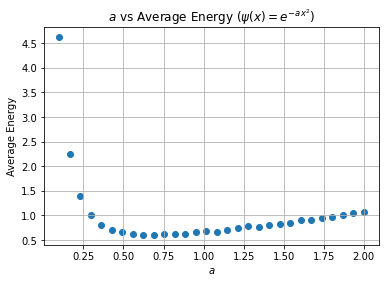

a value with minimum average energy: 0.6825795905705315
min energy: 0.5989326150033573


In [4]:
plt.scatter(a_vals, energies)
plt.title("$a$ vs Average Energy ($\psi(x) = e^{-ax^2}$)")
plt.xlabel("$a$")
plt.ylabel("Average Energy")
plt.grid()
plt.show()
print("a value with minimum average energy: "+ str(a_min))
print("min energy: " + str(avg_energy(10**4, a_min)))